<a href="https://colab.research.google.com/github/roberttwomey/beyond-tbb-code/blob/main/backgrounds/CLIP-StyleGAN3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP-guided StyleGAN3

This notebook explore text-guided image generation with [StyleGan3](https://github.com/NVlabs/stylegan3) using [CLIP](https://openai.com/research/clip) for text-guidance.

Written by [nshepperd](https://twitter.com/nshepperd1). Thanks to [Katherine Crowson](https://twitter.com/RiversHaveWings) for coming up with many improved sampling tricks, as well as some of the code. Adapted for ML for the Arts.

---
[UPD 13.12.2021] Fix painted faces model download

[UPD 04.12.2021] Add parameter to freeze camera movement

[UPD 21.11.2021] Exposed learning rate parameter

[UPD 20.11.2021] Added Landscapes 256 model

[UPD 10.11.2021] Added WikiArt model

[UPD 24.12.2021] Added experimental image prompts


## Prompting Parameters

Change the **text_prompt** below, as well as the **model**. This will iteratively adapt the starting image (seed+model) to align with the text prompt.

In [58]:
# Text to modify the face
text_prompt = "a city at night"  #@param {type: "string"}
text_prompt_weight = 1. #@param {type: "number"}

# Additional image that will be treated like a text prompt. If it's a zip, we take an average of all the images / experimental
image_prompt_file = "" #@param {type: "string"}
images_prompt_weight =  0 #@param {type: "number"}

# Fix camera so it's not moving around
fix_camera = True #@param {type: "boolean"}

# Speed at which to try approximating the text. Too fast seems to give strange results. Maximum is 100.
speed = 20  #@param {type: "number"}

# How many steps to run. Each step generates one frame.
steps = 75 #@param {type: "number"}

# Change the seed to generate variations of the same prompt
seed = 64 #@param {type: "number"}

# Model type to use.
model = 'Landscapes 256'  #@param ['Painted Faces', 'Animal Faces', 'Flickr Faces', 'Wiki Art', 'Landscapes 256']

# We haven't completely understood which parameters influence the generation of this model. Changing the learning rate could help (between 0 and 100)
learning_rate = 4#2 #@param {type: "number"}

model_map = {
    'Painted Faces': 'https://ipfs.pollinations.ai/ipfs/QmWiZxHpNJdyFujgB6bYwsDg3gT2mnAvpZ9MhZniPcLXGU/stylegan3-r-metfacesu-1024x1024.pkl',
    'Animal Faces': 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-afhqv2-512x512.pkl',
    'Flickr Faces': 'https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-ffhqu-1024x1024.pkl',
    'Wiki Art': 'https://ipfs.pollinations.ai/ipfs/QmZkrYwEUnykVQJfJw3opTj1HfdNUCm87amsR3LHp1QnuV/wikiart-1024-stylegan3-t-17.2Mimg.pkl',
    'Landscapes 256': 'https://ipfs.pollinations.ai/ipfs/QmZkrYwEUnykVQJfJw3opTj1HfdNUCm87amsR3LHp1QnuV/lhq-256-stylegan3-t-25Mimg.pkl'
}

output_path = "/content/mnt/sg3-out"

#@markdown ---


social = False

In [ ]:
model_url = model_map[model]
smoothing = (100.0-speed)/100.0

## Setup

In [ ]:
# Check GPU and CUDA
!nvidia-smi
!nvcc --version

In [ ]:
# #!pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install --upgrade torch==1.11.0+cu113 torchvision==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install einops ninja
# #!pip install --upgrade https://download.pytorch.org/whl/nightly/cu111/torch-1.11.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl https://download.pytorch.org/whl/nightly/cu111/torchvision-0.12.0.dev20211012%2Bcu111-cp37-cp37m-linux_x86_64.whl
# !git clone https://github.com/NVlabs/stylegan3
    !git clone https://github.com/openai/CLIP
# !pip install -e ./CLIP
# !pip install einops ninja

In [ ]:
import sys
sys.path.append('./CLIP')
sys.path.append('./stylegan3')

# import tensorflow
import io
import os, time
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import clip
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display, clear_output
from einops import rearrange

In [ ]:
device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)
torch.manual_seed(seed)

In [ ]:
# Define necessary functions

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def fetch_model(url_or_path):
    basename = os.path.basename(url_or_path)
    if os.path.exists(basename):
        return basename
    else:
        !wget -N '{url_or_path}'
        return basename

def norm1(prompt):
    "Normalize to the unit sphere."
    return prompt / prompt.square().sum(dim=-1,keepdim=True).sqrt()

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)

class MakeCutouts(torch.nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(F.adaptive_avg_pool2d(cutout, self.cut_size))
        return torch.cat(cutouts)

make_cutouts = MakeCutouts(224, 32, 0.5)

def embed_image(image):
  n = image.shape[0]
  cutouts = make_cutouts(image)
  embeds = clip_model.embed_cutout(cutouts)
  embeds = rearrange(embeds, '(cc n) c -> cc n c', n=n)
  return embeds


def embed_img_file(path):
  image = Image.open(path).convert('RGB')
  return embed_image(TF.to_tensor(image).to(device).unsqueeze(0)).mean(0).squeeze(0)

def embed_url(url):
  image = Image.open(fetch(url)).convert('RGB')
  return embed_image(TF.to_tensor(image).to(device).unsqueeze(0)).mean(0).squeeze(0)

In [ ]:
class CLIP(object):
  def __init__(self):
    clip_model = "ViT-B/32"
    self.model, _ = clip.load(clip_model)
    self.model = self.model.requires_grad_(False)
    self.normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                          std=[0.26862954, 0.26130258, 0.27577711])

  @torch.no_grad()
  def embed_text(self, prompt):
      "Normalized clip text embedding."
      return norm1(self.model.encode_text(clip.tokenize(prompt).to(device)).float())

  def embed_cutout(self, image):
      "Normalized clip image embedding."
      return norm1(self.model.encode_image(self.normalize(image)))

clip_model = CLIP()

In [ ]:
# Load stylegan model

network_url = model_url

# with open(fetch_model(network_url), 'rb') as fp:
#   G = pickle.load(fp)['G_ema'].to(device)

with open("lhq-256-stylegan3-t-25Mimg.pkl", 'rb') as fp:
  G = pickle.load(fp)['G_ema'].to(device)


# Fix the coordinate grid to w_avg
if fix_camera:
  shift = G.synthesis.input.affine(G.mapping.w_avg.unsqueeze(0))
  G.synthesis.input.affine.bias.data.add_(shift.squeeze(0))
  G.synthesis.input.affine.weight.data.zero_()

# # Arbitrary coordinate grid (dubious idea)
# with torch.no_grad():
#   grid = G.synthesis.input(G.mapping.w_avg.unsqueeze(0))
#   def const(x):
#     def f(w):
#       n = w.shape[0]
#       return x.broadcast_to([n, *x.shape[1:]])
#     return f
#   G.synthesis.input.forward = const(grid)
# grid.requires_grad_()

zs = torch.randn([10000, G.mapping.z_dim], device=device)
w_stds = G.mapping(zs, None).std(0)

In [ ]:
# Run Settings

target = clip_model.embed_text(text_prompt)
#target = embed_url("https://4.bp.blogspot.com/-uw859dFGsLc/Va5gt-bU9bI/AAAAAAAA4gM/dcaWzX0ZxdI/s1600/Lubjana+dragon+1.jpg")
# target = embed_url("https://irc.zlkj.in/uploads/e399d2fee2c6edd9/20210827165231_0_nexus%20of%20abandoned%20places.%20trending%20on%20ArtStation.png")


In [ ]:
from glob import glob
if image_prompt_file.endswith(".zip"):
  !rm -rf img_prompts/
  !unzip {image_prompt_file} -d img_prompts
  img_extensions = ["png", "jpg", "jpeg"]
  image_prompts = [i for i in glob("img_prompts/*") if i.split(".")[-1] in img_extensions]
elif image_prompt_file != "":
  image_prompts = [image_prompt_file]
else:
  image_prompts = []

prompts = [(text_prompt_weight, target)]
for img_file in image_prompts:
  target = embed_img_file(img_file)
  prompts += [(images_prompt_weight/len(image_prompts), target)]

## Run generation Loop

tensor([0.8056], device='cuda:0', grad_fn=<AddBackward0>)


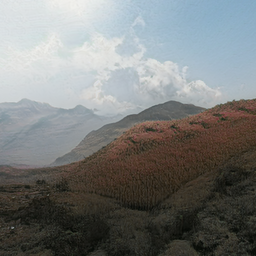

100%|███████████| 75/75 [00:08<00:00,  8.77it/s, loss=0.785, q_magnitude=0.679]


'/tmp/ffmpeg/output_0074.jpg' -> '/tmp/ffmpeg/0000.jpg'
ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enab

In [59]:
# Actually do the run

tf = Compose([
  Resize(224),
  lambda x: torch.clamp((x+1)/2,min=0,max=1),
  ])

def run():
  torch.manual_seed(seed)
  timestring = time.strftime('%Y%m%d%H%M%S')

  # Init
  # Method 1: sample 32 inits and choose the one closest to prompt

#   with torch.no_grad():
#     qs = []
#     losses = []
#     for _ in range(16):
#       q = (G.mapping(torch.randn([4,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
#       images = G.synthesis(q * w_stds + G.mapping.w_avg)
#       embeds = embed_image(images.add(1).div(2))
#       loss = 0
#       for (w, t) in prompts:
#         loss += w * spherical_dist_loss(embeds, t).mean(0)
#       i = torch.argmin(loss)
#       qs.append(q[i])
#       losses.append(loss[i])
#     qs = torch.stack(qs)
#     losses = torch.stack(losses)
#     print(losses)
#     print(losses.shape, qs.shape)
#     i = torch.argmin(losses)
#     q = qs[i].unsqueeze(0).requires_grad_()

  # Method 2: Random init depending only on the seed.

  q = (G.mapping(torch.randn([1,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
  q.requires_grad_()

  # set up file storage
  process_folder = f"{output_path}/{text_prompt[:30]}-{speed}-{learning_rate}-{seed}"
  os.makedirs(process_folder, exist_ok=True)
  os.makedirs("/tmp/ffmpeg", exist_ok=True)
    
  # Sampling loop
  q_ema = q
  opt = torch.optim.AdamW([q], lr=learning_rate/250.0, betas=(0.0,0.999))
  loop = tqdm(range(steps), position=0, leave=True)
  for i in loop:
    opt.zero_grad()
    w = q * w_stds
    image = G.synthesis(w + G.mapping.w_avg, noise_mode='const')
    embed = embed_image(image.add(1).div(2))
    loss = 0
    for (w, t) in prompts:
      loss += w * spherical_dist_loss(embed, t).mean(0)
    # print(loss)
    loss.backward()
    opt.step()
    loop.set_postfix(loss=loss.item(), q_magnitude=q.std().item())

    q_ema = q_ema * smoothing + q * (1-smoothing)
    latent = q_ema * w_stds + G.mapping.w_avg
    image = G.synthesis(latent, noise_mode='const')

    #if i % 10 == 0:
    #  display(TF.to_pil_image(tf(image)[0]))
    pil_image = TF.to_pil_image(image[0].add(1).div(2).clamp(0,1))
    if i % (steps/10) == 0:
      clear_output(wait=True)

      image_out = f"{process_folder}/{i:04}.jpg"
      latent_out = f"{process_folder}/{i:04}.pt"
      pil_image.save(image_out)
      torch.save(latent, latent_out)
    
      print(loss)
      display(pil_image)
    pil_image.save(f'/tmp/ffmpeg/output_{i:04}.jpg')

  image_out = f"{process_folder}/{steps-1}.jpg"
  latent_out = f"{process_folder}/{steps-1}.pt"
  pil_image.save(image_out)
  torch.save(latent, latent_out)
  
  return latent

try:
  latent = run()
  torch.save(latent, f"{output_path}/latent.pt")
except KeyboardInterrupt:
  pass

# save a video
out_file=output_path+f"/{text_prompt[:30]}-{speed}-{learning_rate}-{seed}-{steps}.mp4"
latent_out = f"{text_prompt[:30]}-{speed}-{learning_rate}-{seed}-{steps}.pt"
!cp {output_path}/latent.pt "$output_path/$latent_out"

last_frame=!ls -t /tmp/ffmpeg/*.jpg | head -1
last_frame = last_frame[0]

# Copy last frame to start and duplicate at end so it sticks around longer
!cp -v $last_frame /tmp/ffmpeg/0000.jpg

encoding_options = "-c:v libx264 -crf 20 -preset slow -vf format=yuv420p -c:a aac -movflags +faststart"

!ffmpeg  -r 10 -i /tmp/ffmpeg/%*.jpg -y {encoding_options} /tmp/vid_no_audio.mp4
!ffmpeg -i /tmp/vid_no_audio.mp4 -f lavfi -i anullsrc -c:v copy -c:a aac -shortest -y "$out_file"

print("Written", out_file)
!sleep 2

!rm -r /tmp/ffmpeg

## Save out video and latent vector

In [ ]:
# out_file=output_path+f"/{text_prompt[:30]}-{speed}-{learning_rate}-{seed}-{steps}.mp4"
# latent_out = f"{text_prompt[:30]}-{speed}-{learning_rate}-{seed}-{steps}.pt"
# !cp {output_path}/latent.pt "$output_path/$latent_out"

# last_frame=!ls -t /tmp/ffmpeg/*.jpg | head -1
# last_frame = last_frame[0]

# # Copy last frame to start and duplicate at end so it sticks around longer
# !cp -v $last_frame /tmp/ffmpeg/0000.jpg

# encoding_options = "-c:v libx264 -crf 20 -preset slow -vf format=yuv420p -c:a aac -movflags +faststart"

# !ffmpeg  -r 10 -i /tmp/ffmpeg/%*.jpg -y {encoding_options} /tmp/vid_no_audio.mp4
# !ffmpeg -i /tmp/vid_no_audio.mp4 -f lavfi -i anullsrc -c:v copy -c:a aac -shortest -y "$out_file"

# print("Written", out_file)
# !sleep 2

# !rm -r /tmp/ffmpeg

Open the file browser at left and download `video.mp4` to save it to your local machine.